In [1]:
from func import *
import pandas as pd
import numpy as np


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
import string
import re

import spacy
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.tokens import Doc
import numpy
from nltk.corpus import stopwords
import string
import re

### Load the data

In [2]:
df = load_data(data = 'musical')

In [3]:
df.shape

(10261, 9)

In [12]:
X = df['reviewText']
y = df['overall']

#### 

### Data Cleaning

In [4]:
def get_top_bottom_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n], words_freq[-n:]

In [5]:
freq_words, infreq_words = get_top_bottom_n_words(df['reviewText'], n=100)

In [6]:
def remove_tokens_on_match(doc):
    indexes = []
    for index, token in enumerate(doc):
        if token.is_stop:
            indexes.append(index)
        if (token.pos_  in ('PUNCT', 'NUM', 'SYM')):
            indexes.append(index)
    np_array = doc.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA])

    np_array = numpy.delete(np_array, indexes, axis = 0)
    doc2 = Doc(doc.vocab, words=[t.lemma_ for i, t in enumerate(doc) if i not in indexes])
    doc2.from_array([LOWER, POS, ENT_TYPE, IS_ALPHA], np_array)
    return doc2

nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])
nlp.add_pipe(nlp.create_pipe('sentencizer'))
nlp.add_pipe(remove_tokens_on_match, name="custom_model_wrapper", last=True)

print(nlp.pipe_names)  # ['tagger', 'parser', 'ner', 'print_info']
doc = nlp("This is a 4 sentences running.")
# for token in doc:
#     print(token.lemma_)
print(doc.text)

I1103 16:01:55.001188 4563981760 file_utils.py:39] PyTorch version 1.2.0 available.
I1103 16:01:55.039225 4563981760 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


['tagger', 'sentencizer', 'custom_model_wrapper']
sentence run 


In [13]:
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])
nlp.add_pipe(remove_tokens_on_match, name="custom_model_wrapper", last=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


print("Parsing texts...")
train_docs = list(nlp.pipe(X_train))
dev_docs = list(nlp.pipe(X_test))

Parsing texts...


In [29]:
def get_labelled_sentences(docs, doc_labels):
    labels = []
    sentences = []
    for doc, y in zip(docs, doc_labels):
        sentences.append(doc.text)
        labels.append(y)
    return sentences, numpy.asarray(labels, dtype="int32")

In [48]:
train_data, y_train = get_labelled_sentences(train_docs, y_train)
test_data, y_test = get_labelled_sentences(dev_docs, y_test)

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_features(docs, n):

    # Initialize a TfidfVectorizer object: tfidf_vectorizer
    tfidf_vectorizer = TfidfVectorizer(lowercase=False, stop_words="english", ngram_range=(1, n), max_df=0.99, min_df=0.01)

    # Transform the training data: tfidf_train 
    tfidf_df = tfidf_vectorizer.fit_transform(docs)
    return tfidf_df

In [50]:
train_feature = get_features(train_data, 2)
test_feature = get_features(test_data, 2)

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.datasets import load_digits
from sklearn.svm import LinearSVC, SVC

from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('model', SVC())
])

# single categorical value of 'model' parameter is 
# sets the model class
# We will get ConvergenceWarnings because the problem is not well-conditioned.
# But that's fine, this is just an example.
linsvc_search = {
    'model': [LinearSVC(max_iter=1000)],
    'model__C': (1e-6, 1e+6, 'log-uniform'),
}

# explicit dimension classes can be specified like this
svc_search = {
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

opt = BayesSearchCV(
    pipe,
    [(svc_search, 20), (linsvc_search, 16)], # (parameter space, # of evaluations)
    cv=3
)

opt.fit(train_feature, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

In [59]:
! pip install scikit-optimize

     |████████████████████████████████| 81kB 1.7MB/s eta 0:00:01


In [7]:
# def text_normalization(doc):
#     nlp = spacy.load('en_core_web_sm')
#     punctuations = string.punctuation
#     doc = nlp(doc, disable=['parser', 'ner'])
#     tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
# #     tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
#     tokens = ' '.join(tokens)
#     return tokens
# normalize_corpus = np.vectorize(text_normalization)
# df['reviewText_norm'] = normalize_corpus(df['reviewText'])

In [8]:

# def doc_normalization(doc):
#     # lower case and remove special characters\whitespaces
#     doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
#     return doc
# normalize_corpus2 = np.vectorize(doc_normalization)

In [230]:
df['reviewText_norm1'] = normalize_corpus2(df['reviewText_norm'])

In [253]:
X = df['reviewText_norm1']
y = df['overall']

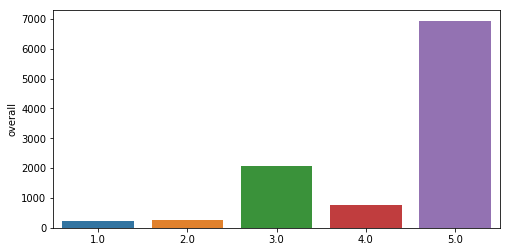

In [339]:
fig = plt.figure(figsize=(8,4))
sns.barplot(x = y.unique(), y=y.value_counts())
plt.show()

In [401]:
lr_classifier.coef_

array([[  4.18954969,   9.71784293,   2.61209824, ...,  -7.36065031,
          9.63490509,  17.44544087],
       [  4.08139378,  16.95146386,   6.28309358, ...,  -1.01094267,
         16.25371694, -15.86553132],
       [ -2.22079883,  -9.53135864, -10.78474115, ...,   2.30957298,
         -8.37513194,  -0.55010412],
       [ -3.38914669,  -8.88140091,   0.93966102, ...,   2.94122731,
         -8.56182499,  -0.47323822],
       [ -2.66099795,  -8.25654723,   0.94988831, ...,   3.12079269,
         -8.9516651 ,  -0.55656721]])

In [402]:
feature_names = count_vectorizer.get_feature_names()
coefs_with_fns = sorted(zip(lr_classifier.coef_[1], feature_names))

In [404]:
def printNMostInformative(vectorizer, clf, N):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns_1 = sorted(zip(clf.coef_[0], feature_names))
    coefs_with_fns_2 = sorted(zip(clf.coef_[1], feature_names))
    coefs_with_fns_3 = sorted(zip(clf.coef_[2], feature_names))
    coefs_with_fns_4 = sorted(zip(clf.coef_[3], feature_names))
    coefs_with_fns_5 = sorted(zip(clf.coef_[4], feature_names))
    topClass1 = coefs_with_fns_1[:N]
    topClass2 = coefs_with_fns_2[:N]
    topClass3 = coefs_with_fns_3[:N]
    topClass4 = coefs_with_fns_4[:N]
    topClass5 = coefs_with_fns_5[:N]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)
    print("Class 3 best: ")
    for feat in topClass3:
        print(feat)
    print("Class 4 best: ")
    for feat in topClass4:
        print(feat)
    print("Class 5 best: ")
    for feat in topClass5:
        print(feat)

In [406]:
printNMostInformative(count_vectorizer, lr_classifier, 15)

Class 1 best: 
(-29.204402286374467, 'option')
(-27.840546778395055, 'guy')
(-27.797088541698155, 'suppose')
(-25.5520944699803, 'plan')
(-25.43985038464847, 'hit')
(-24.527600727074635, 'peg')
(-23.776952564981293, 'favorite')
(-23.398133943576514, 'probably')
(-22.379679906569336, 'expect')
(-21.19470398846132, 'particular')
(-20.816322131522433, 'string sound')
(-20.569628916895166, 'edge')
(-20.229851931322198, 'recently')
(-20.177408097359283, 'pitch')
(-19.962573814628257, 'turn')
Class 2 best: 
(-96.03952673383505, 'red')
(-83.21681824885088, 'body')
(-74.0987313020265, 'arrive')
(-71.88763685405871, 'center')
(-70.8305296309087, 'little bit')
(-67.1023761653878, 'vocal')
(-66.2774242663929, 'exactly')
(-66.24714624804609, 'mix')
(-65.46152053523342, 'just fine')
(-63.31121622726044, 'mess')
(-63.16498836286109, 'mandolin')
(-62.73790666607934, 'string use')
(-62.15661042928743, 'high end')
(-59.314347013333574, 'course')
(-58.663426200857515, 'really good')
Class 3 best: 
(-12.

### Print the Most Frequent words for each class

In [ ]:
INFO_text = [text for text in X_train[X_train['Conference'] == 'INFOCOM']['Title']]
IS_text = [text for text in train[train['Conference'] == 'ISCAS']['Title']]
INFO_clean = cleanup_text(INFO_text)
INFO_clean = ' '.join(INFO_clean).split()
IS_clean = cleanup_text(IS_text)
IS_clean = ' '.join(IS_clean).split()
INFO_counts = Counter(INFO_clean)
IS_counts = Counter(IS_clean)
INFO_common_words = [word[0] for word in INFO_counts.most_common(20)]
INFO_common_counts = [word[1] for word in INFO_counts.most_common(20)]
fig = plt.figure(figsize=(18,6))
sns.barplot(x=INFO_common_words, y=INFO_common_counts)
plt.title('Most Common Words used in the research papers for conference INFOCOM')
plt.show()

# Import the necessary modules


### Bag of words

In [ ]:
np.linalg.cond(tfidf_train.toarray())

In [391]:
np.linalg.cond(tfidf_train.toarray())

57.796461273932955

In [374]:
# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words = "english", ngram_range=(1, 2), min_df=.01, max_df=.99)

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'tex t' column values: count_test 
count_test = count_vectorizer.transform(X_test)

# Print the first 10 features of the count_vectorizer
print(count_vectorizer.get_feature_names()[:700])

['able', 'absolutely', 'ac', 'accurate', 'acoustic', 'acoustic electric', 'acoustic guitar', 'action', 'actually', 'adapter', 'add', 'adjust', 'adjustable', 'adjustment', 'advertise', 'ago', 'allow', 'amazing', 'amazon', 'amp', 'angle', 'apart', 'appear', 'arm', 'arrive', 'ask', 'attach', 'audio', 'available', 'away', 'awesome', 'bad', 'bag', 'ball', 'band', 'bar', 'base', 'basic', 'basically', 'bass', 'battery', 'beat', 'beginner', 'behringer', 'believe', 'bend', 'best', 'better', 'big', 'bit', 'black', 'blue', 'board', 'body', 'boost', 'boss', 'box', 'brand', 'break', 'bridge', 'bright', 'bring', 'buck', 'budget', 'build', 'build quality', 'button', 'buy', 'buzz', 'cable', 'capo', 'care', 'carry', 'case', 'cause', 'center', 'certainly', 'chain', 'change', 'change string', 'channel', 'cheap', 'check', 'choice', 'choose', 'chord', 'clamp', 'classic', 'clean', 'clear', 'clip', 'close', 'cloth', 'color', 'come', 'comfortable', 'compact', 'company', 'compare', 'complain', 'complaint', 'co

In [375]:
len(count_vectorizer.get_feature_names())

633

In [392]:
count_train.toarray().shape

(6874, 633)

In [341]:
# stop_words = set(count_vectorizer.get_feature_names()[:700])

# X_train1 = X_train.apply(lambda sentence: 
#                          ' '.join([word for word in sentence.split() if word.lower() not in stop_words])) #

# X_train

# X_train1

# X_test1 = X_test.apply(lambda sentence: 
#                        ' '.join([word for word in sentence.split() if word.lower() not in stop_words])) #

In [342]:
# # Initialize a CountVectorizer object: count_vectorizer
# count_vectorizer1 = CountVectorizer(stop_words = "english")

# # Transform the training data using only the 'text' column values: count_train 
# count_train = count_vectorizer1.fit_transform(X_train1)

# # Transform the test data using only the 'tex t' column values: count_test 
# count_test = count_vectorizer1.transform(X_test1)

# # Print the first 10 features of the count_vectorizer
# print(count_vectorizer1.get_feature_names()[:300])

### Cross Validation

In [367]:
# Import the necessary modules
from sklearn import metrics
# from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
scoring = {'accuracy': make_scorer(accuracy_score),
            'prec': 'precision'}

# Instantiate a Multinomial Naive Bayes classifier: lr_classifier
lr_classifier = LogisticRegression(C=1e5, solver='newton-cg', multi_class='multinomial') 
                    #, class_weight = weights)

scores = cross_validate(lr_classifier, count_train, y_train, cv=3,
                         scoring=['accuracy', 'f1_weighted'],
                         return_train_score=True)



/Users/ZYe/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ZYe/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [368]:
scores

{'fit_time': array([0.33208585, 0.32400393, 0.24904299]),
 'score_time': array([0.00259519, 0.00169301, 0.002002  ]),
 'test_accuracy': array([0.66768426, 0.67568747, 0.67641921]),
 'train_accuracy': array([0.6780179 , 0.67706742, 0.67822862]),
 'test_f1_weighted': array([0.54921086, 0.55338102, 0.55846713]),
 'train_f1_weighted': array([0.55869991, 0.55555631, 0.56038014])}

### tfidf

In [ ]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_df=0.99, min_df=0.01)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10])

# Print the first 5 vectors of the tfidf training data
print(tfidf_train.A[:5])

In [ ]:
# Create the CountVectorizer DataFrame: count_df
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

# Print the head of count_df
print(count_df.head())

# Print the head of tfidf_df
print(tfidf_df.head())

# Calculate the difference in columns: difference
difference = set(count_df.columns) - set(tfidf_df.columns)
print(difference)

# Check whether the DataFrames are equal
print(count_df.equals(tfidf_df))

### Cross Validation

In [385]:
# Instantiate a Multinomial Naive Bayes classifier: lr_classifier
lr_classifier = LogisticRegression(C=1e5, solver='newton-cg', multi_class='multinomial') 
                    #, class_weight = weights)

scores = cross_validate(lr_classifier, tfidf_train, y_train, cv=3,
                         scoring=['accuracy', 'f1_weighted'],
                         return_train_score=True)

In [386]:
scores

{'fit_time': array([8.70167112, 9.3029089 , 7.52045417]),
 'score_time': array([0.00242686, 0.00211096, 0.00213671]),
 'test_accuracy': array([0.60052333, 0.6001746 , 0.60305677]),
 'train_accuracy': array([0.7987339 , 0.8020947 , 0.79057592]),
 'test_f1_weighted': array([0.59032733, 0.58622763, 0.59111767]),
 'train_f1_weighted': array([0.7828489 , 0.7856703 , 0.77327812])}

### Train

In [400]:
# Instantiate a Multinomial Naive Bayes classifier: lr_classifier
lr_classifier = LogisticRegression(C=1e5, solver='newton-cg', multi_class='multinomial')

# Fit the classifier to the training data
lr_classifier.fit(count_train,y_train)

# Create the predicted tags: pred
pred = lr_classifier.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
# from sklearn.metrics import multilabel_confusion_matrix
# cm = multilabel_confusion_matrix(y_test, pred, labels=['1Star',"2Star", '3Star', '4Star', '5Star'])
# print(cm)

0.6194272217301446


/Users/ZYe/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [ ]:
"""
Here we will use logistic regression model trained
using Keras in spaCy. spaCy splits the document into sentences, and each
sentence is classified using the LSTM. The scores for the sentences are then
aggregated to give the document score. This kind of hierarchical model is quite
difficult in "pure" Keras or Tensorflow, but it's very effective. The Keras
example on this dataset performs quite poorly, because it cuts off the documents
so that they're a fixed size. This hurts review accuracy a lot, because people
often summarise their rating in the final sentence
Prerequisites:
spacy download en_vectors_web_lg
pip install keras==2.0.9
Compatible with: spaCy v2.0.0+
"""

import plac
import random
import pathlib
import cytoolz
import numpy
from keras.models import Sequential, model_from_json
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from keras.layers import TimeDistributed
from keras.optimizers import Adam
import thinc.extra.datasets
from spacy.compat import pickle
import spacy


class SentimentAnalyser(object):
    @classmethod
    def load(cls, path, nlp, max_length=100):
        with (path / "config.json").open() as file_:
            model = model_from_json(file_.read())
        with (path / "model").open("rb") as file_:
            lstm_weights = pickle.load(file_)
        embeddings = get_embeddings(nlp.vocab)
        model.set_weights([embeddings] + lstm_weights)
        return cls(model, max_length=max_length)

    def __init__(self, model, max_length=100):
        self._model = model
        self.max_length = max_length

    def __call__(self, doc):
        X = get_features([doc], self.max_length)
        y = self._model.predict(X)
        self.set_sentiment(doc, y)

    def pipe(self, docs, batch_size=1000):
        for minibatch in cytoolz.partition_all(batch_size, docs):
            minibatch = list(minibatch)
            sentences = []
            for doc in minibatch:
                sentences.extend(doc.sents)
            Xs = get_features(sentences, self.max_length)
            ys = self._model.predict(Xs)
            for sent, label in zip(sentences, ys):
                sent.doc.sentiment += label - 0.5
            for doc in minibatch:
                yield doc

    def set_sentiment(self, doc, y):
        doc.sentiment = float(y[0])
        # Sentiment has a native slot for a single float.
        # For arbitrary data storage, there's:
        # doc.user_data['my_data'] = y


def get_labelled_sentences(docs, doc_labels):
    labels = []
    sentences = []
    for doc, y in zip(docs, doc_labels):
        for sent in doc.sents:
            sentences.append(sent)
            labels.append(y)
    return sentences, numpy.asarray(labels, dtype="int32")

from sklearn.feature_extraction.text import TfidfVectorizer
def get_features(docs, n):

    # Initialize a TfidfVectorizer object: tfidf_vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, n), max_df=0.99, min_df=0.01)

    # Transform the training data: tfidf_train 
    tfidf_df = tfidf_vectorizer.fit_transform(docs)
    return tfidf_df
#     docs = list(docs)
#     Xs = numpy.zeros((len(docs), max_length), dtype="int32")
#     for i, doc in enumerate(docs):
#         j = 0
#         for token in doc:
#             vector_id = token.vocab.vectors.find(key=token.orth)
#             if vector_id >= 0:
#                 Xs[i, j] = vector_id
#             else:
#                 Xs[i, j] = 0
#             j += 1
#             if j >= max_length:
#                 break
#     return Xs

def remove_tokens_on_match(doc):
    indexes = []
    for index, token in enumerate(doc):
        if token.is_stop:
            indexes.append(index)
        if (token.pos_  in ('PUNCT', 'NUM', 'SYM')):
            indexes.append(index)
    np_array = doc.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA])

    np_array = numpy.delete(np_array, indexes, axis = 0)
    doc2 = Doc(doc.vocab, words=[t.lemma_ for i, t in enumerate(doc) if i not in indexes])
    doc2.from_array([LOWER, POS, ENT_TYPE, IS_ALPHA], np_array)
    return doc2

def train(
    train_texts,
    train_labels,
    dev_texts,
    dev_labels,
    lstm_shape,
    lstm_settings,
    lstm_optimizer,
    batch_size=100,
    nb_epoch=5,
    by_sentence=True,
):

    print("Loading spaCy")
    
    
#     nlp.add_pipe(nlp.create_pipe('sentencizer'))
    

    nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])
    nlp.add_pipe(remove_tokens_on_match, name="custom_model_wrapper", last=True)
#     nlp.add_pipe(nlp.create_pipe("sentencizer"))
#     embeddings = get_embeddings(nlp.vocab)
    model = compile_logisticRegression(c)

    print("Parsing texts...")
    train_docs = list(nlp.pipe(train_texts))
    dev_docs = list(nlp.pipe(dev_texts))
#     if by_sentence:
#         train_docs, train_labels = get_labelled_sentences(train_docs, train_labels)
#         dev_docs, dev_labels = get_labelled_sentences(dev_docs, dev_labels)

    train_X = get_features(train_docs, lstm_shape["max_length"])
    dev_X = get_features(dev_docs, lstm_shape["max_length"])
    model.fit(
        train_X,
        train_labels,
        validation_data=(dev_X, dev_labels),
        epochs=nb_epoch,
        batch_size=batch_size,
    )
    return model


def compile_logisticRegression(c=1e5):
    model = LogisticRegression(C=c, solver='newton-cg', multi_class='multinomial') 
    return model


def get_embeddings(vocab):
    return vocab.vectors.data


def evaluate(model_dir, texts, labels, max_length=100):
    nlp = spacy.load("en_vectors_web_lg")
    nlp.add_pipe(nlp.create_pipe("sentencizer"))
    nlp.add_pipe(SentimentAnalyser.load(model_dir, nlp, max_length=max_length))

    correct = 0
    i = 0
    for doc in nlp.pipe(texts, batch_size=1000):
        correct += bool(doc.sentiment >= 0.5) == bool(labels[i])
        i += 1
    return float(correct) / i


def read_data(data_dir, limit=0):
    examples = []
    for subdir, label in (("pos", 1), ("neg", 0)):
        for filename in (data_dir / subdir).iterdir():
            with filename.open() as file_:
                text = file_.read()
            examples.append((text, label))
    random.shuffle(examples)
    if limit >= 1:
        examples = examples[:limit]
    return zip(*examples)  # Unzips into two lists


@plac.annotations(
    train_dir=("Location of training file or directory"),
    dev_dir=("Location of development file or directory"),
    model_dir=("Location of output model directory",),
    is_runtime=("Demonstrate run-time usage", "flag", "r", bool),
    nr_hidden=("Number of hidden units", "option", "H", int),
    max_length=("Maximum sentence length", "option", "L", int),
    dropout=("Dropout", "option", "d", float),
    learn_rate=("Learn rate", "option", "e", float),
    nb_epoch=("Number of training epochs", "option", "i", int),
    batch_size=("Size of minibatches for training LSTM", "option", "b", int),
    nr_examples=("Limit to N examples", "option", "n", int),
)
def main(
    model_dir=None,
    train_dir=None,
    dev_dir=None,
    is_runtime=False,
    nr_hidden=64,
    max_length=100,  # Shape
    dropout=0.5,
    learn_rate=0.001,  # General NN config
    nb_epoch=5,
    batch_size=256,
    nr_examples=-1,
):  # Training params
    if model_dir is not None:
        model_dir = pathlib.Path(model_dir)
    if train_dir is None or dev_dir is None:
        imdb_data = thinc.extra.datasets.imdb()
    if is_runtime:
        if dev_dir is None:
            dev_texts, dev_labels = zip(*imdb_data[1])
        else:
            dev_texts, dev_labels = read_data(dev_dir)
        acc = evaluate(model_dir, dev_texts, dev_labels, max_length=max_length)
        print(acc)
    else:
        if train_dir is None:
            train_texts, train_labels = zip(*imdb_data[0])
        else:
            print("Read data")
            train_texts, train_labels = read_data(train_dir, limit=nr_examples)
        if dev_dir is None:
            dev_texts, dev_labels = zip(*imdb_data[1])
        else:
            dev_texts, dev_labels = read_data(dev_dir, imdb_data, limit=nr_examples)
        train_labels = numpy.asarray(train_labels, dtype="int32")
        dev_labels = numpy.asarray(dev_labels, dtype="int32")
        lstm = train(
            train_texts,
            train_labels,
            dev_texts,
            dev_labels,
            {"nr_hidden": nr_hidden, "max_length": max_length, "nr_class": 1},
            {"dropout": dropout, "lr": learn_rate},
            {},
            nb_epoch=nb_epoch,
            batch_size=batch_size,
        )
        weights = lstm.get_weights()
        if model_dir is not None:
            with (model_dir / "model").open("wb") as file_:
                pickle.dump(weights[1:], file_)
            with (model_dir / "config.json").open("w") as file_:
                file_.write(lstm.to_json())


if __name__ == "__main__":
    plac.call(main)